In [1]:
!pip install transformers datasets torchaudio librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
!pip install -U librosa numba numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 496.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the 

In [1]:
# Jika ingin menggunakan GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## train model 1 (bhs indonesia) wav2vec 2.0 pretrained model dari facebook/wav2vec2-base (parameter sama dgn pretrained)

In [1]:
# =========================================================
# === 0. IMPORT
# =========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from datasets import Dataset, Audio
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [2]:
def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

In [3]:
def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label


In [4]:
def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [5]:
# =========================================================
# === 2. PREPARE HF DATASET
# =========================================================

def prepare_hf_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_arrays = [x["array"] for x in batch["path"]]
        inputs = processor(audio_arrays, sampling_rate=16000, padding=True, return_tensors="pt")
        inputs["labels"] = batch["label_id"]
        return inputs

    train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [6]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted')
    }

In [7]:
def train_model(
    train_dataset,
    eval_dataset,
    label2id,
    id2label,
    processor,
    output_dir
):

    # Load Pretrained Model
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification"
    )

    # Define Training Arguments
    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-4,
    #     per_device_train_batch_size=4,
    #     per_device_eval_batch_size=4,
    #     gradient_accumulation_steps=2,
    #     num_train_epochs=10,
    #     seed=42,
    #     fp16=True,
    #     save_total_limit=2,
    #     # load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    #     logging_steps=10,
    #     lr_scheduler_type="linear"
    # )
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,                          # ✅ lebih kecil → stabil untuk data kecil
        per_device_train_batch_size=2,              # ✅ batch kecil → lebih hati-hati
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,              # ✅ agar batch efektif tetap besar
        num_train_epochs=10,                        # ✅ cukup banyak, tapi early stopping akan batasi
        warmup_ratio=0.1,                           # ✅ pemanasan, penting untuk dataset kecil
        weight_decay=0.01,                          # ✅ regularisasi ringan
        logging_steps=10,
        seed=42,
        fp16=True,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        lr_scheduler_type="linear"
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3)
        ]
    )

    # === TRAIN ===
    trainer.train()
    trainer.evaluate()

    # === PREDICT ON TEST SET ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # === CLASSIFICATION REPORT ===
    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    # Save Classification Report to CSV
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))
    print(f"\n✅ Classification report saved to: {output_dir}/classification_report.csv")

    # === CONFUSION MATRICES ===
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    # Raw Confusion Matrix
    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    raw_path = os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png")
    plt.savefig(raw_path)
    plt.show()

    # Normalized Confusion Matrix
    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    norm_path = os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png")
    plt.savefig(norm_path)
    plt.show()

    print(f"\n✅ Confusion matrices saved to: {os.path.join(output_dir, 'confusion_matrices')}")

In [8]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# 5.1 Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
output_dir = "/content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/indonesia"

# 5.2 Load Data
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("\n✅ Data Loaded")
print(df.head())
print(df['label'].value_counts())
print("\nTrain Split:")
print(train_df['label'].value_counts())
print("\nTest Split:")
print(test_df['label'].value_counts())


✅ Data Loaded
                                                path    label  label_id
0  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
1  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
2  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
3  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
4  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64

Train Split:
label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64

Test Split:
label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64


In [9]:
# 5.3 Load Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
print("\n✅ Processor Loaded")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(



✅ Processor Loaded


In [10]:
# 5.4 Prepare HF Dataset
train_dataset, eval_dataset = prepare_hf_dataset(train_df, test_df, processor)
print("\n✅ Dataset Prepared")
print(train_dataset)
print(train_dataset.features)

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]


✅ Dataset Prepared
Dataset({
    features: ['label_id', 'input_values', 'labels'],
    num_rows: 192
})
{'label_id': Value(dtype='int64', id=None), 'input_values': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [11]:
import wandb
wandb.init(mode="disabled")

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-153388167.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArgumen

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.385400,1.371623,0.270833,0.139163,0.190217,0.270833
2,1.332300,1.209920,0.583333,0.491814,0.669258,0.583333
3,1.075500,1.169149,0.500000,0.402632,0.370879,0.500000
4,0.937700,0.946645,0.750000,0.738529,0.835883,0.750000
5,0.693400,0.586149,0.937500,0.937291,0.941558,0.937500
6,0.508400,0.504626,0.916667,0.915898,0.925000,0.916667
7,0.329400,0.462477,0.916667,0.915638,0.930769,0.916667
8,0.240300,0.374308,0.937500,0.936508,0.950000,0.937500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Classification Report ===
              precision    recall  f1-score   support

     disgust       0.91      0.83      0.87        12
       happy       1.00      0.92      0.96        12
     neutral       0.86      1.00      0.92        12
    surprise       1.00      1.00      1.00        12

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48


✅ Classification report saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/indonesia/classification_report.csv


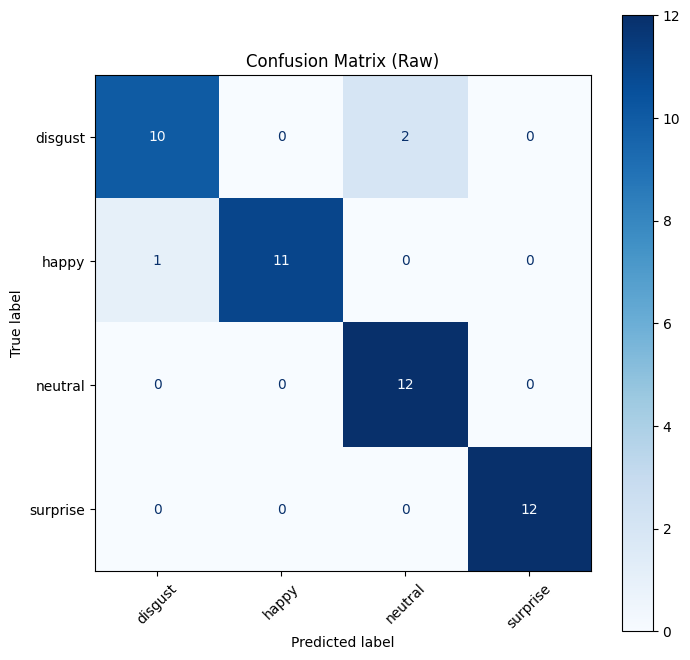

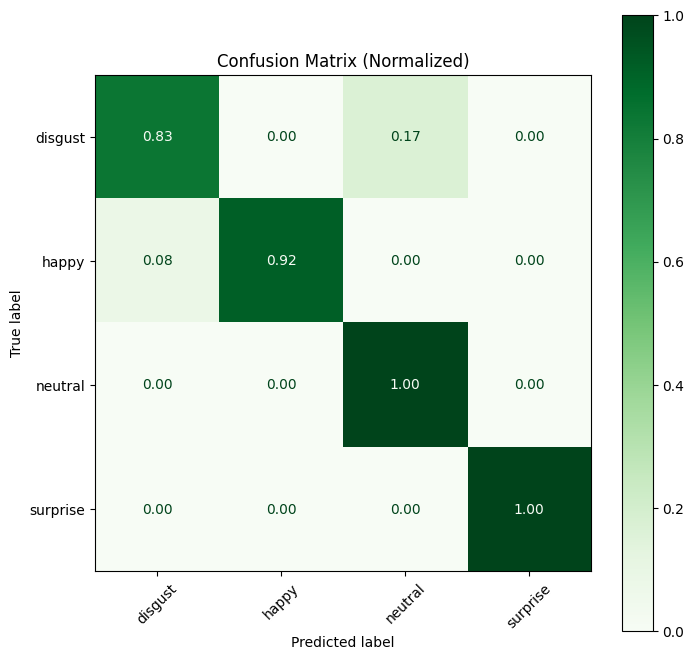


✅ Confusion matrices saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/indonesia/confusion_matrices


In [12]:
# 5.6 Train Model
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir)

## train model 2 (bhs inggris) wav2vec 2.0 base model (parameter sama dgn pretrained)

In [1]:
# =========================================================
# === 0. IMPORT
# =========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from datasets import Dataset, Audio
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [2]:
def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

In [3]:
def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label


In [4]:
def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [5]:
# =========================================================
# === 2. PREPARE HF DATASET
# =========================================================

def prepare_hf_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_arrays = [x["array"] for x in batch["path"]]
        inputs = processor(audio_arrays, sampling_rate=16000, padding=True, return_tensors="pt")
        inputs["labels"] = batch["label_id"]
        return inputs

    train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [7]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted')
    }

In [14]:
def train_model(
    train_dataset,
    eval_dataset,
    label2id,
    id2label,
    processor,
    output_dir
):

    # Load Pretrained Model
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification"
    )

    # Define Training Arguments
    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=2e-5,
    #     per_device_train_batch_size=8,
    #     per_device_eval_batch_size=8,
    #     gradient_accumulation_steps=2,
    #     num_train_epochs=12,
    #     warmup_ratio=0.1,
    #     weight_decay=0.005,
    #     logging_steps=10,
    #     seed=42,
    #     fp16=True,
    #     save_total_limit=2,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    #     lr_scheduler_type="cosine"
    # )
    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-4,
    #     per_device_train_batch_size=4,
    #     per_device_eval_batch_size=4,
    #     gradient_accumulation_steps=2,
    #     num_train_epochs=10,
    #     seed=42,
    #     fp16=True,
    #     save_total_limit=2,
    #     # load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    #     logging_steps=10,
    #     lr_scheduler_type="linear"
    # )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,                          # ✅ lebih kecil → stabil untuk data kecil
        per_device_train_batch_size=2,              # ✅ batch kecil → lebih hati-hati
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,              # ✅ agar batch efektif tetap besar
        num_train_epochs=10,                        # ✅ cukup banyak, tapi early stopping akan batasi
        warmup_ratio=0.1,                           # ✅ pemanasan, penting untuk dataset kecil
        weight_decay=0.01,                          # ✅ regularisasi ringan
        logging_steps=10,
        seed=42,
        fp16=True,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        lr_scheduler_type="linear"
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3)
        ]
    )

    # === TRAIN ===
    trainer.train()
    trainer.evaluate()

    # === PREDICT ON TEST SET ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # === CLASSIFICATION REPORT ===
    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    # Save Classification Report to CSV
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))
    print(f"\n✅ Classification report saved to: {output_dir}/classification_report.csv")

    # === CONFUSION MATRICES ===
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    # Raw Confusion Matrix
    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    raw_path = os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png")
    plt.savefig(raw_path)
    plt.show()

    # Normalized Confusion Matrix
    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    norm_path = os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png")
    plt.savefig(norm_path)
    plt.show()

    print(f"\n✅ Confusion matrices saved to: {os.path.join(output_dir, 'confusion_matrices')}")

In [15]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# 5.1 Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/inggris"

# 5.2 Load Data
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("\n✅ Data Loaded")
print(df.head())
print(df['label'].value_counts())
print("\nTrain Split:")
print(train_df['label'].value_counts())
print("\nTest Split:")
print(test_df['label'].value_counts())


✅ Data Loaded
                                                path     label  label_id
0  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
1  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
2  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
3  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
4  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64

Train Split:
label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64

Test Split:
label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64


In [16]:
# 5.3 Load Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
print("\n✅ Processor Loaded")


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(



✅ Processor Loaded


In [17]:
# 5.4 Prepare HF Dataset
train_dataset, eval_dataset = prepare_hf_dataset(train_df, test_df, processor)
print("\n✅ Dataset Prepared")
print(train_dataset)
print(train_dataset.features)

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]


✅ Dataset Prepared
Dataset({
    features: ['label_id', 'input_values', 'labels'],
    num_rows: 192
})
{'label_id': Value(dtype='int64', id=None), 'input_values': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [18]:
import wandb
wandb.init(mode="disabled")

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-14-2960376541.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.385500,1.376444,0.291667,0.178571,0.318182,0.291667
2,1.358100,1.296692,0.500000,0.403846,0.486111,0.500000
3,1.173700,1.118103,0.645833,0.583661,0.751623,0.645833
4,0.987100,0.969874,0.708333,0.636772,0.788103,0.708333
5,0.776200,0.753471,0.833333,0.820202,0.836538,0.833333
6,0.716400,0.690491,0.791667,0.748759,0.835119,0.791667
7,0.532200,0.597163,0.875000,0.867663,0.897436,0.875000
8,0.418300,0.600643,0.854167,0.840952,0.879808,0.854167
9,0.334300,0.532195,0.875000,0.867663,0.897436,0.875000
10,0.114100,0.329479,0.916667,0.914222,0.924222,0.916667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Classification Report ===
              precision    recall  f1-score   support

     disgust       0.92      1.00      0.96        12
       happy       1.00      0.75      0.86        12
     neutral       0.86      1.00      0.92        12
    surprise       0.92      0.92      0.92        12

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.91        48
weighted avg       0.92      0.92      0.91        48


✅ Classification report saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/inggris/classification_report.csv


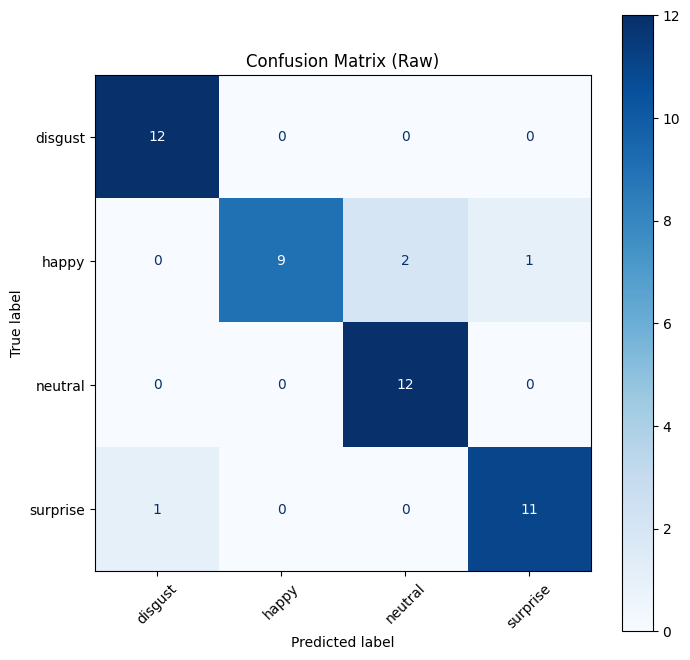

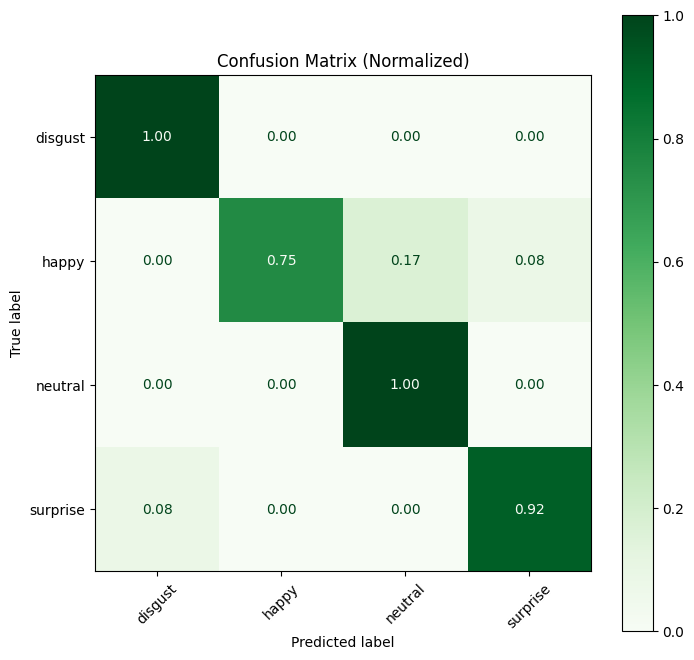


✅ Confusion matrices saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/inggris/confusion_matrices


In [19]:
# 5.6 Train Model
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir)

## train model 3 (bhs gabungan) wav2vec 2.0 base model (parameter sama dgn pretrained)

In [1]:
# =========================================================
# === 0. IMPORT
# =========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from datasets import Dataset, Audio
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [2]:
def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

In [3]:
def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label


In [4]:
def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [5]:
# =========================================================
# === 2. PREPARE HF DATASET
# =========================================================

def prepare_hf_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_arrays = [x["array"] for x in batch["path"]]
        inputs = processor(audio_arrays, sampling_rate=16000, padding=True, return_tensors="pt")
        inputs["labels"] = batch["label_id"]
        return inputs

    train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [6]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='weighted'),
        "precision": precision_score(labels, preds, average='weighted'),
        "recall": recall_score(labels, preds, average='weighted')
    }

In [7]:
def train_model(
    train_dataset,
    eval_dataset,
    label2id,
    id2label,
    processor,
    output_dir
):

    # Load Pretrained Model
    model = Wav2Vec2ForSequenceClassification.from_pretrained(
        "facebook/wav2vec2-base",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification"
    )

    # Define Training Arguments
    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=2e-5,
    #     per_device_train_batch_size=8,
    #     per_device_eval_batch_size=8,
    #     gradient_accumulation_steps=2,
    #     num_train_epochs=12,
    #     warmup_ratio=0.1,
    #     weight_decay=0.005,
    #     logging_steps=10,
    #     seed=42,
    #     fp16=True,
    #     save_total_limit=2,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    #     lr_scheduler_type="cosine"
    # )
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,                          # ✅ lebih kecil → stabil untuk data kecil
        per_device_train_batch_size=2,              # ✅ batch kecil → lebih hati-hati
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,              # ✅ agar batch efektif tetap besar
        num_train_epochs=10,                        # ✅ cukup banyak, tapi early stopping akan batasi
        warmup_ratio=0.1,                           # ✅ pemanasan, penting untuk dataset kecil
        weight_decay=0.01,                          # ✅ regularisasi ringan
        logging_steps=10,
        seed=42,
        fp16=True,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        lr_scheduler_type="linear"
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3)
        ]
    )

    # === TRAIN ===
    trainer.train()
    trainer.evaluate()

    # === PREDICT ON TEST SET ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # === CLASSIFICATION REPORT ===
    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    # Save Classification Report to CSV
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))
    print(f"\n✅ Classification report saved to: {output_dir}/classification_report.csv")

    # === CONFUSION MATRICES ===
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    # Raw Confusion Matrix
    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    raw_path = os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png")
    plt.savefig(raw_path)
    plt.show()

    # Normalized Confusion Matrix
    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    norm_path = os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png")
    plt.savefig(norm_path)
    plt.show()

    print(f"\n✅ Confusion matrices saved to: {os.path.join(output_dir, 'confusion_matrices')}")

In [8]:
# ==== CONFIG UNTUK MODEL 3 ====
allowed_labels = ["disgust", "happy", "neutral", "surprise"]

# Path ke dataset Indonesia & Inggris
indo_data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
eng_data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"

# Load masing-masing dataset
df_indo = load_data_from_folder(indo_data_dir, allowed_labels)
df_eng = load_data_from_folder(eng_data_dir, allowed_labels)

print("\n✅ Loaded raw counts:")
print(df_indo['label'].value_counts())
print(df_eng['label'].value_counts())

# ==== Custom Split: stratified per domain ====
train_indo, test_indo = stratified_split(df_indo)
train_eng, test_eng = stratified_split(df_eng)

print("\n✅ Split Indo:")
print("Train:", train_indo['label'].value_counts())
print("Test:", test_indo['label'].value_counts())

print("\n✅ Split Inggris:")
print("Train:", train_eng['label'].value_counts())
print("Test:", test_eng['label'].value_counts())



✅ Loaded raw counts:
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64

✅ Split Indo:
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64

✅ Split Inggris:
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64


In [9]:
# Gabungkan hasil split
train_df = pd.concat([train_indo, train_eng]).reset_index(drop=True)
test_df  = pd.concat([test_indo, test_eng]).reset_index(drop=True)

print("\n✅ Gabungan Train Split:")
print(train_df['label'].value_counts())
print("\n✅ Gabungan Test Split:")
print(test_df['label'].value_counts())


✅ Gabungan Train Split:
label
happy       96
neutral     96
surprise    96
disgust     96
Name: count, dtype: int64

✅ Gabungan Test Split:
label
disgust     24
surprise    24
neutral     24
happy       24
Name: count, dtype: int64


In [10]:
# ==== Encode Labels
full_df = pd.concat([train_df, test_df]).reset_index(drop=True)
full_df, label2id, id2label = encode_labels(full_df)
train_df["label_id"] = train_df["label"].map(label2id)
test_df["label_id"] = test_df["label"].map(label2id)

print("\n✅ Label Encoding Done")
print("label2id:", label2id)



✅ Label Encoding Done
label2id: {'disgust': 0, 'happy': 1, 'neutral': 2, 'surprise': 3}


In [11]:
# 5.3 Load Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
print("\n✅ Processor Loaded")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(



✅ Processor Loaded


In [12]:
# 5.4 Prepare HF Dataset
train_dataset, eval_dataset = prepare_hf_dataset(train_df, test_df, processor)
print("\n✅ Dataset Prepared")
print(train_dataset)
print(train_dataset.features)

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]


✅ Dataset Prepared
Dataset({
    features: ['label_id', 'input_values', 'labels'],
    num_rows: 384
})
{'label_id': Value(dtype='int64', id=None), 'input_values': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [13]:
import wandb
wandb.init(mode="disabled")

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-7-1360498009.py:62: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArgume

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.376700,1.340515,0.468750,0.372927,0.499715,0.468750
2,1.111100,1.002096,0.520833,0.443965,0.463015,0.520833
3,0.869000,0.778742,0.687500,0.650852,0.679203,0.687500
4,0.722000,0.607511,0.708333,0.657995,0.699185,0.708333
5,0.515000,0.764812,0.687500,0.671421,0.677784,0.687500
6,0.388400,0.727623,0.802083,0.798732,0.820764,0.802083
7,0.275400,0.368486,0.906250,0.905404,0.918269,0.906250
8,0.266900,0.411804,0.895833,0.891109,0.908050,0.895833
9,0.106100,0.382953,0.906250,0.906385,0.924318,0.906250
10,0.117900,0.425802,0.895833,0.896058,0.911048,0.895833


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      0.83      0.91        24
       happy       0.95      0.79      0.86        24
     neutral       0.80      1.00      0.89        24
    surprise       0.92      1.00      0.96        24

    accuracy                           0.91        96
   macro avg       0.92      0.91      0.91        96
weighted avg       0.92      0.91      0.91        96


✅ Classification report saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/gabungan/classification_report.csv


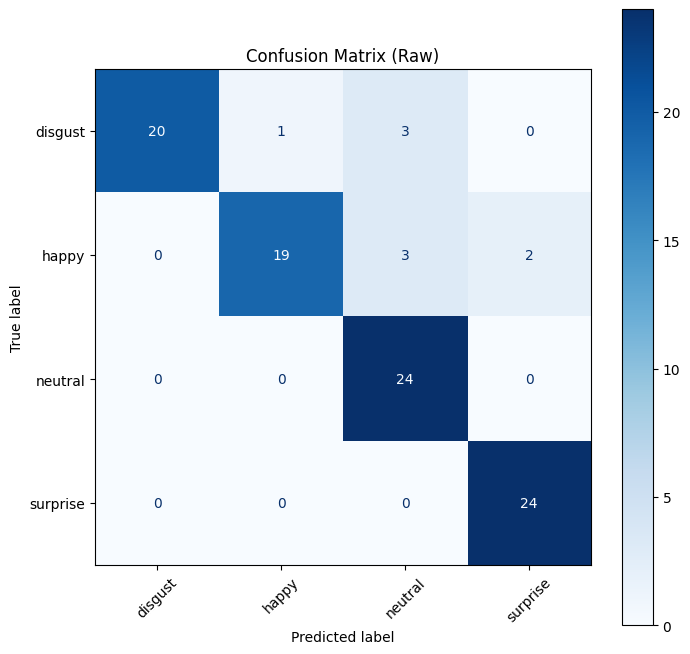

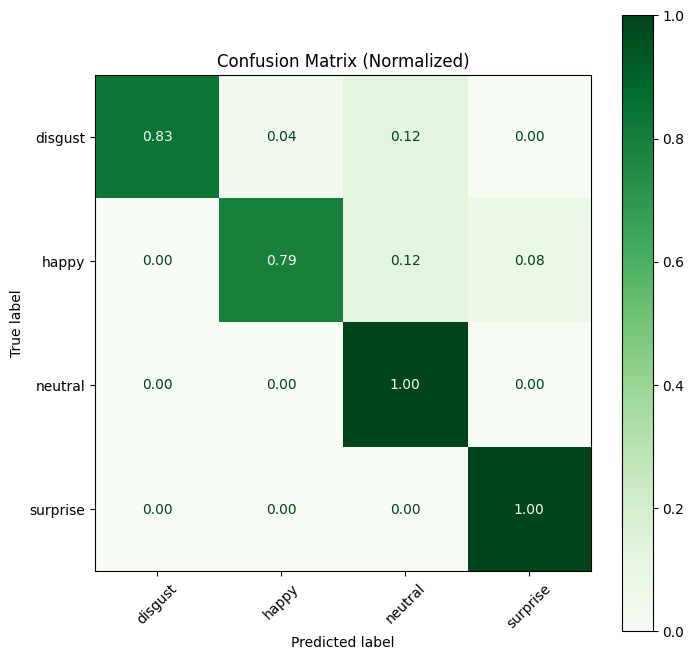


✅ Confusion matrices saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/gabungan/confusion_matrices


In [14]:
# 5.6 Train Model
output_dir = "/content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/gabungan"
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir)

## test model 1 (bhs indonesia) menggunakan dataset inggris

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, Audio
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, Trainer


In [2]:
def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({"path": os.path.join(label_dir, file), "label": label.lower()})
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df, label2id):
    df["label_id"] = df["label"].map(label2id)
    return df


In [3]:
def prepare_hf_dataset_from_df(df, processor):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_arrays = [x["array"] for x in batch["path"]]
        inputs = processor(audio_arrays, sampling_rate=16000, padding=True, return_tensors="pt")
        inputs["labels"] = batch["label_id"]
        return inputs

    dataset = dataset.map(preprocess, batched=True, remove_columns=["path", "label"])
    return dataset


In [4]:
def evaluate_model_on_dataset(model_dir, test_data_dir, allowed_labels, label2id, id2label, output_dir_eval):
    os.makedirs(output_dir_eval, exist_ok=True)

    print(f"\n=== Loading model from {model_dir}")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(model_dir)
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

    # Load test data
    df_test = load_data_from_folder(test_data_dir, allowed_labels)
    df_test = encode_labels(df_test, label2id)
    print(f"Test samples: {len(df_test)}")
    print(df_test['label'].value_counts())

    # Prepare HF Dataset
    test_dataset = prepare_hf_dataset_from_df(df_test, processor)

    # Init Trainer
    trainer = Trainer(
        model=model,
        tokenizer=processor
    )

    # Predict
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    target_names = [id2label[i] for i in sorted(id2label.keys())]

    # Classification Report
    report = classification_report(labels, preds, target_names=target_names)
    print("\n=== CLASSIFICATION REPORT ===")
    print(report)

    # Save report
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir_eval, "classification_report.csv"))
    print(f"Classification report saved to: {os.path.join(output_dir_eval, 'classification_report.csv')}")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    fig.savefig(os.path.join(output_dir_eval, "confusion_matrix_raw.png"))
    plt.show()

    # Normalized CM
    cm_norm = confusion_matrix(labels, preds, normalize="true")
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(8,8))
    disp_norm.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    fig.savefig(os.path.join(output_dir_eval, "confusion_matrix_norm.png"))
    plt.show()

    print(f"Confusion matrices saved to: {output_dir_eval}")


In [5]:
import wandb
wandb.init(mode="disabled")


=== Loading model from /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/indonesia/checkpoint-192


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Test samples: 240
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

/tmp/ipython-input-4-555381172.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     disgust       1.00      0.05      0.10        60
       happy       0.19      0.28      0.23        60
     neutral       0.54      1.00      0.70        60
    surprise       0.11      0.07      0.08        60

    accuracy                           0.35       240
   macro avg       0.46      0.35      0.28       240
weighted avg       0.46      0.35      0.28       240

Classification report saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/evaluation/indo_model_on_ravdess/classification_report.csv


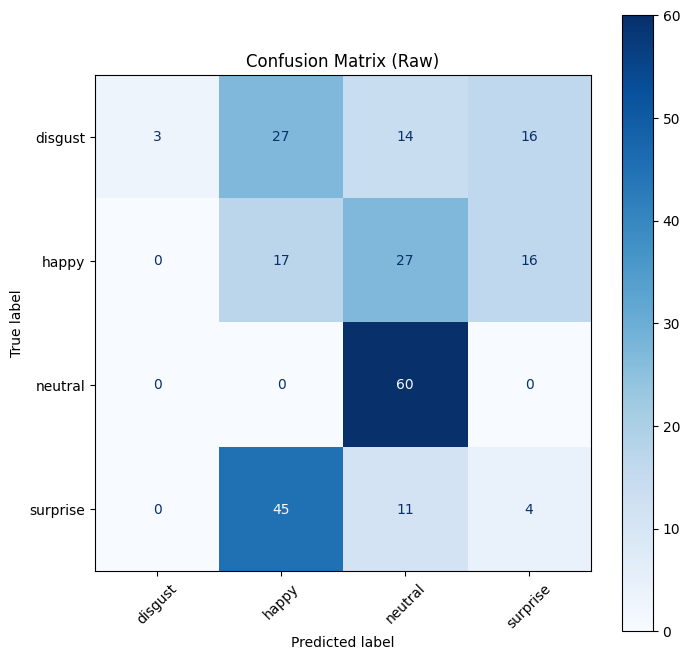

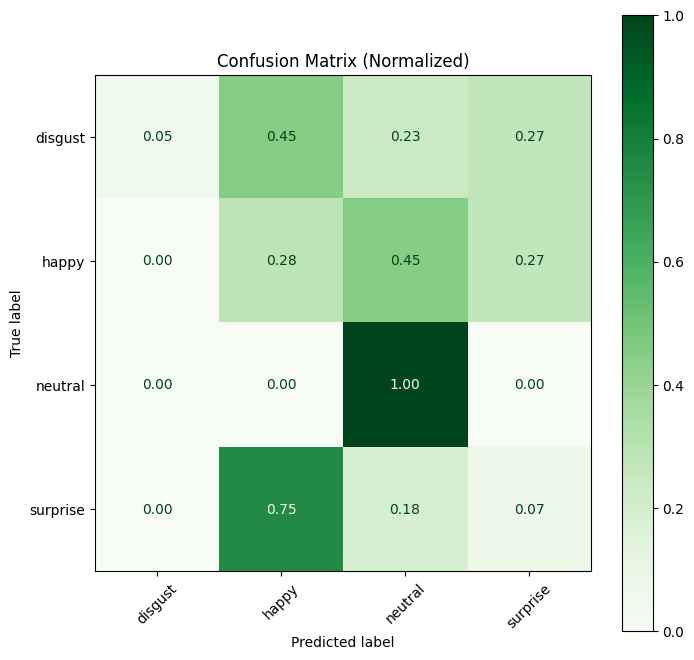

Confusion matrices saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/evaluation/indo_model_on_ravdess


In [7]:
# === Model 1 (Indonesia) tested on English ===
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
label2id = {"disgust": 0, "happy": 1, "neutral": 2, "surprise": 3}
id2label = {v:k for k,v in label2id.items()}

evaluate_model_on_dataset(
    model_dir="/content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/indonesia/checkpoint-192",    # path model 1
    test_data_dir="/content/drive/MyDrive/dataset/normalized_audio_emotions", # path test ravdess
    allowed_labels=allowed_labels,
    label2id=label2id,
    id2label=id2label,
    output_dir_eval="/content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/evaluation/indo_model_on_ravdess"
)


## test model 2 (bhs inggris) menggunakan dataset indonesia

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset, Audio
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, Trainer


In [2]:
def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({"path": os.path.join(label_dir, file), "label": label.lower()})
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df, label2id):
    df["label_id"] = df["label"].map(label2id)
    return df


In [3]:
def prepare_hf_dataset_from_df(df, processor):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_arrays = [x["array"] for x in batch["path"]]
        inputs = processor(audio_arrays, sampling_rate=16000, padding=True, return_tensors="pt")
        inputs["labels"] = batch["label_id"]
        return inputs

    dataset = dataset.map(preprocess, batched=True, remove_columns=["path", "label"])
    return dataset


In [4]:
def evaluate_model_on_dataset(model_dir, test_data_dir, allowed_labels, label2id, id2label, output_dir_eval):
    os.makedirs(output_dir_eval, exist_ok=True)

    print(f"\n=== Loading model from {model_dir}")
    model = Wav2Vec2ForSequenceClassification.from_pretrained(model_dir)
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

    # Load test data
    df_test = load_data_from_folder(test_data_dir, allowed_labels)
    df_test = encode_labels(df_test, label2id)
    print(f"Test samples: {len(df_test)}")
    print(df_test['label'].value_counts())

    # Prepare HF Dataset
    test_dataset = prepare_hf_dataset_from_df(df_test, processor)

    # Init Trainer
    trainer = Trainer(
        model=model,
        tokenizer=processor
    )

    # Predict
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    target_names = [id2label[i] for i in sorted(id2label.keys())]

    # Classification Report
    report = classification_report(labels, preds, target_names=target_names)
    print("\n=== CLASSIFICATION REPORT ===")
    print(report)

    # Save report
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir_eval, "classification_report.csv"))
    print(f"Classification report saved to: {os.path.join(output_dir_eval, 'classification_report.csv')}")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    fig.savefig(os.path.join(output_dir_eval, "confusion_matrix_raw.png"))
    plt.show()

    # Normalized CM
    cm_norm = confusion_matrix(labels, preds, normalize="true")
    disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    fig, ax = plt.subplots(figsize=(8,8))
    disp_norm.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    fig.savefig(os.path.join(output_dir_eval, "confusion_matrix_norm.png"))
    plt.show()

    print(f"Confusion matrices saved to: {output_dir_eval}")


In [5]:
import wandb
wandb.init(mode="disabled")


=== Loading model from /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/inggris/checkpoint-312


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:309: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Test samples: 240
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

/tmp/ipython-input-4-555381172.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     disgust       0.75      0.45      0.56        60
       happy       0.25      0.53      0.34        60
     neutral       0.80      0.13      0.23        60
    surprise       0.51      0.55      0.53        60

    accuracy                           0.42       240
   macro avg       0.58      0.42      0.41       240
weighted avg       0.58      0.42      0.41       240

Classification report saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/evaluation/eng_model_on_indo/classification_report.csv


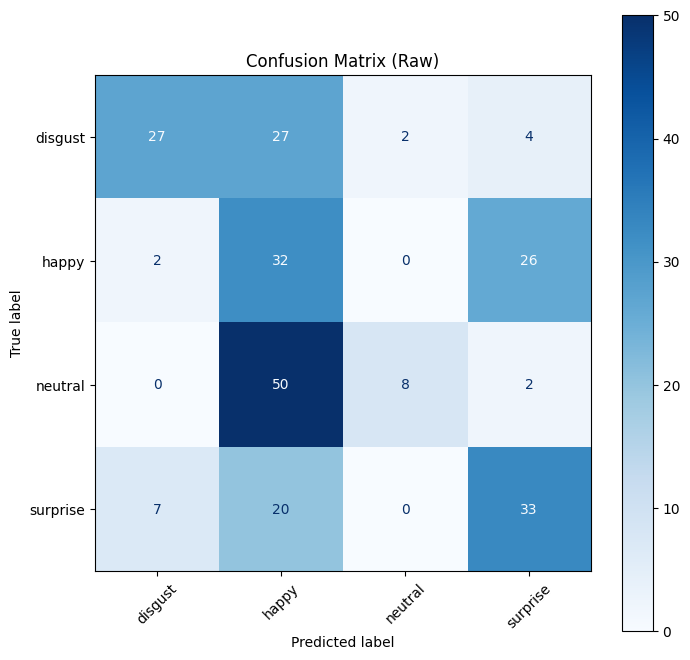

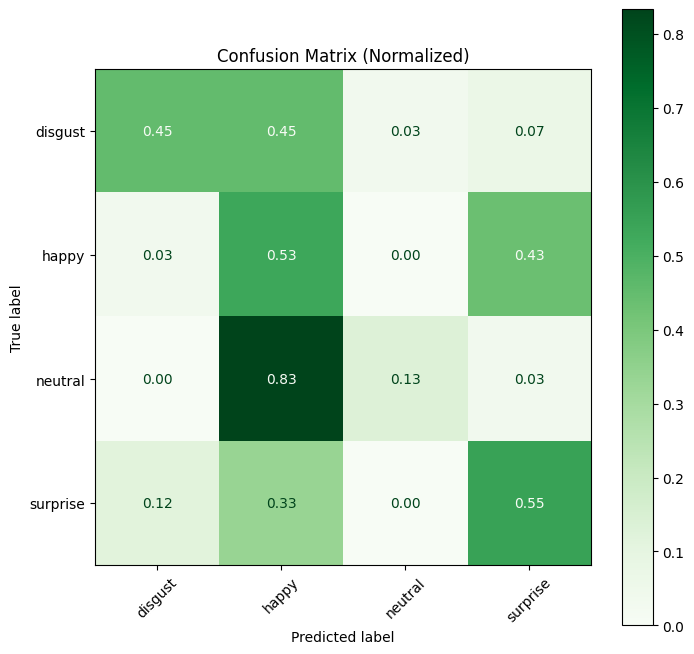

Confusion matrices saved to: /content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/evaluation/eng_model_on_indo


In [6]:
# === Model 2 (inggris) tested on Indonesian ===
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
label2id = {"disgust": 0, "happy": 1, "neutral": 2, "surprise": 3}
id2label = {v:k for k,v in label2id.items()}

evaluate_model_on_dataset(
    model_dir="/content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/inggris/checkpoint-312",    # path model 2
    test_data_dir="/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s", # path test indowavesentiment
    allowed_labels=allowed_labels,
    label2id=label2id,
    id2label=id2label,
    output_dir_eval="/content/drive/MyDrive/model/hasil-train-wav2vec2--basemodel/evaluation/eng_model_on_indo"
)
